# Symbolic Regression

This example combines neural differential equations with regularised evolution to discover the equations

$\frac{\mathrm{d} x}{\mathrm{d} t}(t) = \frac{y(t)}{1 + y(t)}$

$\frac{\mathrm{d} y}{\mathrm{d} t}(t) = \frac{-x(t)}{1 + x(t)}$

directly from data.

**References:**

This example appears as an example in Section 6.1 of:

```bibtex
@phdthesis{kidger2021on,
    title={{O}n {N}eural {D}ifferential {E}quations},
    author={Patrick Kidger},
    year={2021},
    school={University of Oxford},
}
```

Whilst drawing heavy inspiration from:

```bibtex
@inproceedings{cranmer2020discovering,
    title={{D}iscovering {S}ymbolic {M}odels from {D}eep {L}earning with {I}nductive
           {B}iases},
    author={Cranmer, Miles and Sanchez Gonzalez, Alvaro and Battaglia, Peter and
            Xu, Rui and Cranmer, Kyle and Spergel, David and Ho, Shirley},
    booktitle={Advances in Neural Information Processing Systems},
    publisher={Curran Associates, Inc.},
    year={2020},
}

@software{cranmer2020pysr,
    title={PySR: Fast \& Parallelized Symbolic Regression in Python/Julia},
    author={Miles Cranmer},
    publisher={Zenodo},
    url={http://doi.org/10.5281/zenodo.4041459},
    year={2020},
}
```

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/symbolic_regression.ipynb).

In [1]:
import tempfile

import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import pysr  # https://github.com/MilesCranmer/PySR
import sympy
import sympy2jax  # https://github.com/google/sympy2jax


# Note that PySR, which we use for symbolic regression, uses Julia as a backend.
# You'll need to install a recent version of Julia if you don't have one.
# (And can get funny errors if you have a too-old version of Julia already.)
# You may also need to restart Python after running `pysr.install()` the first time.
pysr.install(quiet=True)

Now two helpers. We'll use these in a moment; skip over them for now.

In [2]:
class Stack(eqx.Module):
    modules: list[eqx.Module]

    def __call__(self, x):
        assert x.shape[-1] == 2
        x0 = x[..., 0]
        x1 = x[..., 1]
        return jnp.stack([module(x0=x0, x1=x1) for module in self.modules], axis=-1)


def quantise(expr, quantise_to):
    if isinstance(expr, sympy.Float):
        return expr.func(round(float(expr) / quantise_to) * quantise_to)
    elif isinstance(expr, sympy.Symbol):
        return expr
    else:
        return expr.func(*[quantise(arg, quantise_to) for arg in expr.args])

Okay, let's get started.

We start by running the [Neural ODE example](./neural_ode.ipynb).
Then we extract the learnt neural vector field, and symbolically regress across this.
Finally we fine-tune the resulting symbolic expression.


In [3]:
def main(
    symbolic_dataset_size=2000,
    symbolic_num_populations=100,
    symbolic_population_size=20,
    symbolic_migration_steps=4,
    symbolic_mutation_steps=30,
    symbolic_descent_steps=50,
    pareto_coefficient=2,
    fine_tuning_steps=500,
    fine_tuning_lr=3e-3,
    quantise_to=0.01,
):
    #
    # First obtain a neural approximation to the dynamics.
    # We begin by running the previous example.
    #

    # Runs the Neural ODE example.
    # This defines the variables `ts`, `ys`, `model`.
    print("Training neural differential equation.")
    %run neural_ode.ipynb

    #
    # Now symbolically regress across the learnt vector field, to obtain a Pareto
    # frontier of symbolic equations, that trades loss against complexity of the
    # equation. Select the "best" from this frontier.
    #

    print("Symbolically regressing across the vector field.")
    vector_field = model.func.mlp  # noqa: F821
    dataset_size, length_size, data_size = ys.shape  # noqa: F821
    in_ = ys.reshape(dataset_size * length_size, data_size)  # noqa: F821
    in_ = in_[:symbolic_dataset_size]
    out = jax.vmap(vector_field)(in_)
    with tempfile.TemporaryDirectory() as tempdir:
        symbolic_regressor = pysr.PySRRegressor(
            niterations=symbolic_migration_steps,
            ncyclesperiteration=symbolic_mutation_steps,
            populations=symbolic_num_populations,
            population_size=symbolic_population_size,
            optimizer_iterations=symbolic_descent_steps,
            optimizer_nrestarts=1,
            procs=1,
            model_selection="score",
            progress=False,
            tempdir=tempdir,
            temp_equation_file=True,
        )
        symbolic_regressor.fit(in_, out)
        best_expressions = [b.sympy_format for b in symbolic_regressor.get_best()]

    #
    # Now the constants in this expression have been optimised for regressing across
    # the neural vector field. This was good enough to obtain the symbolic expression,
    # but won't quite be perfect -- some of the constants will be slightly off.
    #
    # To fix this we now plug our symbolic function back into the original dataset
    # and apply gradient descent.
    #

    print("\nOptimising symbolic expression.")

    symbolic_fn = Stack([sympy2jax.SymbolicModule(expr) for expr in best_expressions])
    symbolic_model = eqx.tree_at(lambda m: m.func.mlp, model, symbolic_fn)  # noqa: F821

    @eqx.filter_grad
    def grad_loss(symbolic_model):
        vmap_model = jax.vmap(symbolic_model, in_axes=(None, 0))
        pred_ys = vmap_model(ts, ys[:, 0])  # noqa: F821
        return jnp.mean((ys - pred_ys) ** 2)  # noqa: F821

    optim = optax.adam(fine_tuning_lr)
    opt_state = optim.init(eqx.filter(symbolic_model, eqx.is_inexact_array))

    @eqx.filter_jit
    def make_step(symbolic_model, opt_state):
        grads = grad_loss(symbolic_model)
        updates, opt_state = optim.update(grads, opt_state)
        symbolic_model = eqx.apply_updates(symbolic_model, updates)
        return symbolic_model, opt_state

    for _ in range(fine_tuning_steps):
        symbolic_model, opt_state = make_step(symbolic_model, opt_state)

    #
    # Finally we round each constant to the nearest multiple of `quantise_to`.
    #

    trained_expressions = []
    for symbolic_module in symbolic_model.func.mlp.modules:
        expression = symbolic_module.sympy()
        expression = quantise(expression, quantise_to)
        trained_expressions.append(expression)

    print(f"Expressions found: {trained_expressions}")

Training neural differential equation.
Step: 0, Loss: 0.16657482087612152, Computation time: 11.210124731063843
Step: 100, Loss: 0.01115578692406416, Computation time: 0.002620220184326172
Step: 200, Loss: 0.006481764372438192, Computation time: 0.0026247501373291016
Step: 300, Loss: 0.0013819701271131635, Computation time: 0.003179311752319336
Step: 400, Loss: 0.0010746140033006668, Computation time: 0.0031697750091552734
Step: 499, Loss: 0.0007994902553036809, Computation time: 0.0031609535217285156
Step: 0, Loss: 0.028307927772402763, Computation time: 11.210363626480103
Step: 100, Loss: 0.005411561578512192, Computation time: 0.020294666290283203
Step: 200, Loss: 0.004366496577858925, Computation time: 0.022084712982177734
Step: 300, Loss: 0.0018046485492959619, Computation time: 0.022309064865112305
Step: 400, Loss: 0.001767474808730185, Computation time: 0.021766185760498047
Step: 499, Loss: 0.0011962582357227802, Computation time: 0.022264480590820312


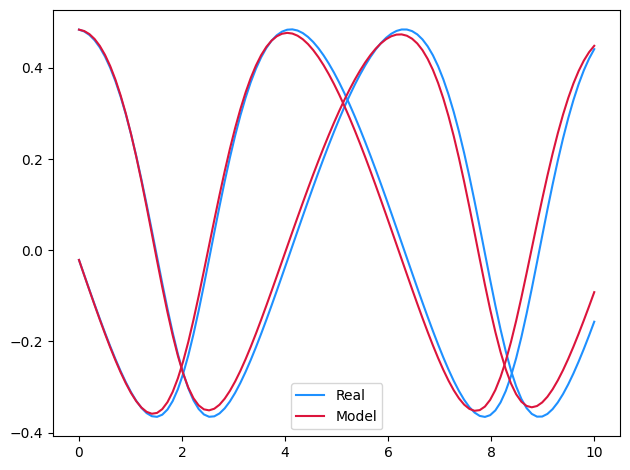

Symbolically regressing across the vector field.


Started!

Cycles per second: 5.190e+03
Head worker occupation: 3.3%
Progress: 434 / 800 total iterations (54.250%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.883e-02  1.206e+00  x1
3           2.746e-02  2.877e-01  (x1 + -0.14616892)
5           6.162e-04  1.899e+00  (x1 / (x1 - -1.0118991))
7           4.476e-04  1.598e-01  ((x1 / 0.92953163) / (x1 + 1.0533974))
9           3.997e-04  5.664e-02  (((x1 * 1.0935224) + -0.008988203) / (x1 + 1.0716586))
13          3.364e-04  4.306e-02  (x1 * ((((x0 * -0.94923264) / 11.808947) - -1.087501) / (x1 + 1.0548282)))
15          3.062e-04  4.714e-02  (x1 * ((((x0 * (-1.1005011 - x1)) / 13.075972) - -1.0955853) / (x1 + 1.0604433)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.588e-01  -1.000e-10  -0.002322703
3           2.034e-02  1.028e+00  (0.14746223 - 

In [4]:
main()